In [1]:
using Flux
using CUDA
using Distributed

In [2]:
addprocs(16)

16-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17

In [3]:
@everywhere include("sparseir_setting.jl")

In [4]:
tanh5(x) = 5tanh(x)
tanh6(x) = 6tanh(x)
tanh8(x) = 8tanh(x)

tanh8 (generic function with 1 method)

In [40]:
function init_model(n_l::Int, n_gauss::Int, width::Int, depth::Int)
    model = Chain(Dense(n_l, width), (Dense(width, width, softplus) for i in 1:depth)..., Flux.Parallel(vcat, Dense(width, n_gauss, tanh), Dense(width, n_gauss, tanh6), Dense(width, n_gauss, tanh5)))
end

function init_model2(n_l::Int, n_gauss::Int, width::Int, depth::Int)
    model = Chain(Dense(n_l, width), BatchNorm(width), (Chain(Dense(width, width, softplus), BatchNorm(width)) for i in 1:depth)..., Flux.Parallel(vcat, Dense(width, n_gauss, tanh), Dense(width, n_gauss, tanh6), Dense(width, n_gauss, tanh5)))
end
function init_model4(n_l::Int, n_gauss::Int, width::Int, depth::Int)
    model = Chain(Dense(n_l, width), LayerNorm(width), (Chain(Dense(width, width, softplus), LayerNorm(width)) for i in 1:depth)..., Flux.Parallel(vcat, Dense(width, n_gauss, tanh), Dense(width, n_gauss, tanh6), Dense(width, n_gauss, tanh5)))
end

function init_model3(n_l::Int, n_gauss::Int, width::Int, depth::Int)
    dd = div(depth, 2)
    model = Chain(Dense(n_l, width), (Chain(BatchNorm(width), Dense(width, width, softplus), Dense(width, width, softplus) ) for i in 1:dd)..., Flux.Parallel(vcat, Dense(width, n_gauss, tanh), Dense(width, n_gauss, tanh6), Dense(width, n_gauss, tanh5)))
end
#const proj5 = proj_m(5) |> gpu
function loss(model::Chain, K::Int, in, ans, λ::Float32)
    out = cpu(model(cu(in)))
    l = size(out)[2]
    phi = softmax(out[2K+1:3K,:])
    mu = out[1:K,:]
    logs = out[K+1:2K,:]
    sigma = exp.(logs)
    logts = ans[K+1:2K, :]
    true_sigma = exp.(logts)
    loss = sum(phi.*(((mu .- ans[1:K,:])./ sigma).^2 + (true_sigma./sigma).^2 - 2logts + 2logs)) + λ * sum(phi.*log.(phi ./ (ans[2K+1:3K, :] .+ 1f-10))) - 1.0f0
    return loss/l
end

function loss4(model::Chain, K::Int, in, ans, λ::Float32)
    out = cpu(model(cu(in)))
    l = size(out)[2]
    phi = softmax(out[2K+1:3K,:])
    mu = out[1:K,:]
    logs = out[K+1:2K,:]
    sigma = exp.(logs)
    logts = ans[K+1:2K, :]
    true_sigma = exp.(logts)
    loss = sum(phi.*(((mu .- ans[1:K,:])./ sigma).^2 + (true_sigma./sigma - sigma./true_sigma).^2)) + λ * sum(phi.*log.(phi ./ (ans[2K+1:3K, :] .+ 1f-10)))
    return loss/l
end

function loss3(model::Chain, K::Int, in, ans, λ::Float32)
    out = cpu(model(cu(in)))
    l = size(out)[2]
    phi = softmax(out[2K+1:3K,:])
    mu = out[1:K,:]
    logs = out[K+1:2K,:]
    sigma = exp.(logs)
    logts = ans[K+1:2K, :]
    true_sigma = exp.(logts)
    loss = sum(phi.*((mu .- ans[1:K,:]).^2 ./ sigma + (true_sigma./sigma) + (logts - logs).^2 )) + λ * sum(phi.*log.(phi ./ (ans[2K+1:3K, :] .+ 1f-8)))
    return loss/l
end

function loss1(model::Chain, K::Int, in, ans, λ::Float32)
    out = cpu(model(cu(in)))
    l = size(out)[2]
    phi = softmax(out[2K+1:3K,:])
    true_phi = ans[2K+1:3K, :]

    mu = out[1:K,:]
    logs = out[K+1:2K,:]
    sigma = exp.(logs)
    logts = ans[K+1:2K, :]
    true_sigma = exp.(logts)
    loss = sum(true_phi.*((mu .- ans[1:K,:])./ true_sigma).^2 + (sigma./true_sigma).^2 - 2logs + 2logts) + λ * sum(true_phi.* (log.(true_phi) .- log.(phi)))
    return loss/l
end

function loss2(model::Chain, K::Int, in, ans, λ::Float32)
    out = cpu(model(cu(in)))
    l = size(out)[2]
    phi = softmax(out[2K+1:3K,:])
    true_phi = ans[2K+1:3K, :]
    mu = out[1:K,:]
    sigma = out[K+1:2K,:]
    loss = sum(true_phi .* ((mu .- ans[1:K,:]).^2 ./ exp.(sigma./2) + (sigma .- ans[K+1:2K,:]).^2)) + λ * sum(phi.*log.(phi ./ (true_phi .+ 1f-10)))
    return loss/l
end

loss2 (generic function with 1 method)

In [6]:
@everywhere using SharedArrays 

In [7]:
function dataset(n::Int, w_size::Int, n_gauss::Int, ir::IR_params)
    l = length(ir.basis.s)
    inputs = SharedArray(zeros(Float32, l, n))
    outputs = SharedArray(zeros(Float32, 3n_gauss, n))
    @sync @distributed for i in 1:n
        inputs[:,i], outputs[:,i] = create_data5(w_size, n_gauss, ir)
    end
    return Matrix(inputs), Matrix(outputs)
end

dataset (generic function with 1 method)

In [8]:
ir_test = set_IR(100.0, 1.0, 1e-6)

IR_params(100.0, 1.0, FiniteTempBasis{Fermionic, LogisticKernel}(LogisticKernel(100.0), SparseIR.SVEResult{LogisticKernel}(SparseIR.PiecewiseLegendrePoly[SparseIR.PiecewiseLegendrePoly(10, -1.0, 1.0, [-1.0, -0.9971969191007053, -0.9939631887430201, -0.9902327485573953, -0.9859294594055299, -0.9809655949653976, -0.9752401232983684, -0.9686367577352446, -0.9610217593708021, -0.9522414800459728  …  0.9522414800459728, 0.9610217593708021, 0.9686367577352446, 0.9752401232983684, 0.9809655949653976, 0.9859294594055299, 0.9902327485573953, 0.9939631887430201, 0.9971969191007053, 1.0], [0.0028030808992947076, 0.0032337303576851495, 0.0037304401856248504, 0.004303289151865397, 0.004963864440132304, 0.005725471667029192, 0.0066033655631237975, 0.00761499836444246, 0.008780279324829388, 0.010121832962441735  …  0.010121832962441735, 0.008780279324829388, 0.00761499836444246, 0.0066033655631237975, 0.005725471667029192, 0.004963864440132304, 0.004303289151865397, 0.0037304401856248504, 0.003233730

In [9]:
@everywhere function gparams2data(p::gParams)
    ord = sortperm(p.ϕ)
    return [p.μ[ord]..., log.(p.Σ[ord])..., p.ϕ[ord]...]
    #return [p.μ..., p.Σ..., p.ϕ...]
end

In [10]:
using ProgressMeter

In [12]:
K=5

5

In [81]:
using JLD2

In [41]:
dt_test = Flux.DataLoader(dataset(8192, 4001, K, ir_test), batchsize=1024, shuffle=true)

8-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=1024)
  with first element:
  (21×1024 Matrix{Float32}, 15×1024 Matrix{Float32},)

In [13]:
dt_test2 = Flux.DataLoader(dataset(4096, 4001, K, ir_test), batchsize=1024, shuffle=true)

4-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=1024)
  with first element:
  (21×1024 Matrix{Float32}, 15×1024 Matrix{Float32},)

In [82]:
@save "data_4096.jld2" dt_test2

In [83]:
@save "data_8192.jld2" dt_test

In [ ]:
using Plots

create data!


Progress: 100%|█████████████████████████████████████████| Time: 0:30:15m17


it: 1, loss: 1.0948294
it: 1, loss: 1.0923688


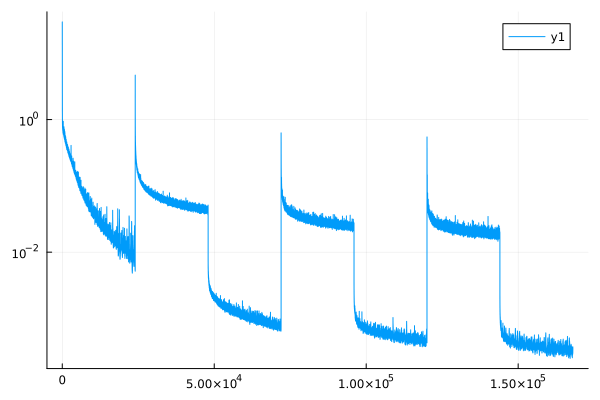

In [42]:

l = length(ir_test.basis.s)
term = 3000

model_test = init_model4(l, K, 256, 16) |> gpu
test_data = []
lss = []
for it in 1:1
    if(it < 5)
        opt = Flux.Optimiser(WeightDecay(1f-5), Adam(2f-4))
        opt_state = Flux.setup(opt, model_test) 
    elseif(it < 13)
        opt = Flux.Optimiser(WeightDecay(1f-6), Adam(1f-4))
        #opt_state = Flux.setup(opt, model_test)
    else
        opt = Flux.Optimiser(WeightDecay(1f-5), Adam(2f-5))
        #opt_state = Flux.setup(opt, model_test) 
    end
    dt = dt_test
    #@time dt = Flux.DataLoader(dataset(4096, 4001, K, ir_test), batchsize=512, shuffle=true)
    #@time dt = Flux.DataLoader(dataset(64, 4001, K, ir_test), batchsize=32, shuffle=true)
    println("create data!")
    #=
    @showprogress for epoch in 1:2000
        #for (input, target) in dt
        for (input, target) in dt
            val, grads = Flux.withgradient(Flux.params(model_test)) do
            #grads = Flux.gradient(Flux.params(model_test)) do
                loss2(model_test, K, input, target, 2.0f0)
            end
            Flux.Optimise.update!(opt, Flux.params(model_test), grads)
            #Flux.update!(opt_state, model_test, grads[1])
            push!(lss, val)
        end
        if(epoch == 250)
            opt = Flux.Optimiser(WeightDecay(1f-6), Adam(2f-4))
        elseif(epoch == 500)
            opt = Flux.Optimiser(WeightDecay(1f-6), Adam(5f-5))
        elseif(epoch == 1000)
            opt = Flux.Optimiser(WeightDecay(1f-6), Adam(1f-5))
            #Flux.adjust!(opt_state, 1f-3)
            #println("epoch: $(epoch), loss: $(lss[end])")
        end
        #=Flux.train!(model_test, dt, opt_state) do m,x,y
            loss(m, K, x, y, 2.0f0)
        end=#
    end=#
    @showprogress for epoch in 1:7term
        if(epoch % 2term < term + 1)
            if(epoch%(2term) == 0)
                opt = Flux.Optimiser(WeightDecay(1f-7), Adam(1f-5))
            end
            for (input, target) in dt
                val, grads = Flux.withgradient(Flux.params(model_test)) do
                #grads = Flux.gradient(Flux.params(model_test)) do
                    loss2(model_test, K, input, target, 0.1f0)
                end
                Flux.Optimise.update!(opt, Flux.params(model_test), grads)
                #Flux.update!(opt_state, model_test, grads[1])
                push!(lss, val)
            end
        else
            if(epoch % 2term == term + 1)
                opt = Flux.Optimiser(WeightDecay(1f-6), Adam(1f-5))
            end
            for (input, target) in dt
                val, grads = Flux.withgradient(Flux.params(model_test)) do
                #grads = Flux.gradient(Flux.params(model_test)) do
                    loss4(model_test, K, input, target, 5.0f0)
                end
                Flux.Optimise.update!(opt, Flux.params(model_test), grads)
                #Flux.update!(opt_state, model_test, grads[1])
                push!(lss, val)
            end
        end
        #=Flux.train!(model_test, dt, opt_state) do m,x,y
            loss(m, K, x, y, 2.0f0)
        end=#
    end
    test = first(dt)
    println("it: $(it), loss: $(loss(model_test, K, test[1], test[2], 2.0f0))")
    println("it: $(it), loss: $(loss(model_test, K, test[1], test[2], 0.0f0))")
    push!(test_data, test)
end
plot(lss,yaxis=:log10)

In [15]:
using Plots

In [25]:
function gmm1(K::Int, w::Float32, μ::Vector{Float32}, Σ::Vector{Float32}, ϕ::Vector{Float32})
    #μ, Σ, ϕ = p.μ, p.Σ, p.ϕ
    y = sum([ϕ[i]*pdf(Normal(μ[i], Σ[i]), w) for i in 1:K])
    return y
end
#=
function data2dist(out::Vector{Float32}, K::Int, w_size::Int)
    ws = [range(-1.0f0,1.0f0, length=w_size)...]
    l = length(out)
    phi = out[2K+1:3K]
    mu = out[1:K]
    sigma = out[K+1:2K]
    rho = [gmm1(K, w, mu, sigma, phi) for w in ws]
    return rho
end=#

function data2dist(out::Vector{Float32}, K::Int, w_size::Int)
    ws = [range(-1.0f0,1.0f0, length=w_size)...]
    l = length(out)
    phi = out[2K+1:3K]
    mu = out[1:K]
    sigma = exp.(out[K+1:2K])
    rho = [gmm1(K, w, mu, sigma, phi) for w in ws]
    return rho
end

function out2dist(out::Vector{Float32}, K::Int, w_size::Int)
    ws = [range(-1.0f0,1.0f0, length=w_size)...]
    l = length(out)
    phi = softmax(out[2K+1:3K])
    mu = out[1:K]
    sigma = exp.(out[K+1:2K])
    rho = [gmm1(K, w, mu, sigma, phi) for w in ws]
    return rho
end

out2dist (generic function with 1 method)

Float32[0.38781008; -0.58095115; 0.71593845; -0.4089227; -0.46487212;;]
Float32[0.0040654964; 0.11020297; 0.36312312; 0.45225; 2.0213115;;]
Float32[0.0019911455; 0.022186868; 0.07527207; 0.3615919; 0.538958;;]
Float32[0.45542085, -0.5804991, 0.7239159, -0.41683394, -0.46515796]
Float32[0.0038370837, 0.10893039, 0.364278, 0.45021152, 2.0293403]
Float32[0.0012792571, 0.022610074, 0.07515741, 0.36093068, 0.54002255]
Float32[-0.06761077, -0.00045204163, -0.007977426, 0.007911235, 0.00028583407, 0.05782318, 0.0116147995, -0.0031753778, 0.004517615, -0.0039641857, 1.4336233, -1.418297, -2.5664012, -3.8491826, -4.0747414]


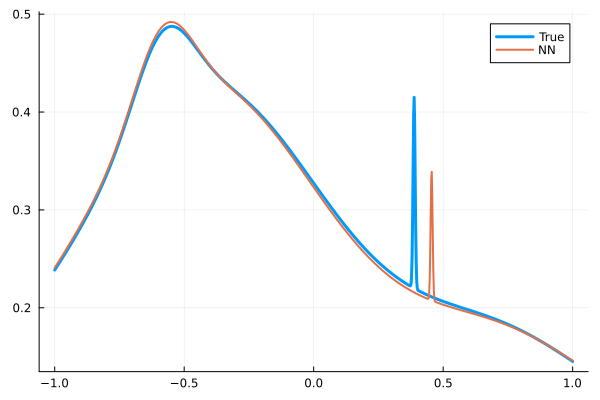

In [75]:
test_gl, gmm_test = test_data[1]
#create_data5(4001, K, ir_test)
id = 314
println(gmm_test[1:K,id:id])
println(exp.(gmm_test[K+1:2K,id:id]))
println(gmm_test[2K+1:3K,id:id])
test_out = cpu(model_test(cu(test_gl[:,id:id])))
println(test_out[1:K,1])
println(exp.(test_out[K+1:2K,1]))
println(softmax(test_out[2K+1:3K,1]))
rho_true = data2dist(gmm_test[:,id], K, 1001)
println(gmm_test[:,id]-test_out[:,1])
rho_NN = out2dist(test_out[:,1], K, 1001)
ws_test = [range(-1.0f0,1.0f0, length=1001)...]
plot(ws_test, rho_true, linewidth=3, label="True")
plot!(ws_test, rho_NN, linewidth=2, label="NN")

Float32[0.45866543, -0.64453524, -0.95683384, 0.12685211, 0.44068515]
Float32[1.3140632, 0.8110913, 0.548779, 0.26599854, 1.981993]
Float32[0.0035498028, 0.0056833075, 0.0169477, 0.18540883, 0.78841037]
Float32[0.899179, 0.73327214, -0.07627409, 0.07715271, 0.388213]
Float32[0.010911686, 0.29749656, 0.30312958, 0.44373527, 2.243249]
Float32[0.0002023692, 0.03211604, 0.1366434, 0.23496799, 0.59607023]


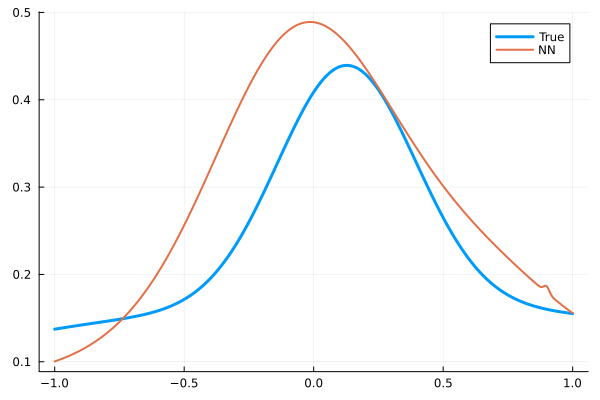

In [80]:
test_gl0, gmm_test0 = create_data5(4001, K, ir_test)
#id = 2
println(gmm_test0[1:K])
println(exp.(gmm_test0[K+1:2K]))
println(gmm_test0[2K+1:3K])
test_out0 = cpu(model_test(cu(test_gl0)))
println(test_out0[1:K])
println(exp.(test_out0[K+1:2K]))
println(softmax(test_out0[2K+1:3K]))
rho_true0 = data2dist(gmm_test0, K, 1001)
rho_NN0 = out2dist(test_out0, K, 1001)
ws_test = [range(-1.0f0,1.0f0, length=1001)...]
plot(ws_test, rho_true0, linewidth=3, label="True")
plot!(ws_test, rho_NN0, linewidth=2, label="NN")